In [9]:
import pickle
import numpy as np
import math
import matplotlib.pyplot as plt

# 截断问题分析

## 工作路径

In [81]:
DATASET_BASE = '/home/LAB/wangd/graduation_project/ranked list truncation/dataset/robust04'
ROBUST_BASE = '/home/LAB/wangd/graduation_project/ranked list truncation/dataset/robust04'
MQ_BASE = '/home/LAB/wangd/graduation_project/ranked list truncation/dataset/mq2007'

## 所用指标是否关于k构成可优化的问题

In [82]:
# 导入ground truth
with open('{}/gt.pkl'.format(DATASET_BASE), 'rb') as f:
    gt = pickle.load(f)
    for key in gt: gt[key] = set(gt[key])

def cal_F1(ranked_list: list, k: int) -> float:
    """
    计算F1 score
    k: 截断到第k个，从1计数
    """
    count, N_D = sum(ranked_list[:k]), sum(ranked_list)
    p_k = count / k
    r_k = (count / N_D) if N_D != 0 else 0
    return (2 * p_k * r_k / (p_k + r_k)) if p_k + r_k != 0 else 0

def cal_DCG(ranked_list: list, k: int, penalty=-1) -> float:
    """
    计算DCG
    """
    value = 0
    for i in range(k): 
        value += (1 / math.log(i + 2, 2)) if ranked_list[i] else (penalty / math.log(i + 2, 2))
    return value

def dataset_prepare(dataset_name: str) -> list:
    # 这里不需要train
    with open('{}/{}_train.pkl'.format(DATASET_BASE, dataset_name), 'rb') as f:
        train_data = pickle.load(f)
    train_rl = {}
    for key in train_data: 
        train_rl[key] = list(map(lambda x: 1 if x in gt[key] else 0, train_data[key].keys()))
    return train_rl

def greedy_scores(dataset_name: str) -> float:
    train_set = dataset_prepare(dataset_name)
    F1_k, DCG_k = [], []
    for key in train_set:
        per_k_F1, per_k_DCG = [0], [0]
        for i in range(1, 301):
            per_k_F1.append(cal_F1(train_set[key], i))
            per_k_DCG.append(cal_DCG(train_set[key], i))
        F1_k.append(per_k_F1)
        DCG_k.append(per_k_DCG)
    
    F1_k_mean, DCG_k_mean = np.mean(np.array(F1_k), axis=0), np.mean(np.array(DCG_k), axis=0)
    return F1_k_mean, DCG_k_mean

In [83]:
f1_bm25, dcg_bm25 = greedy_scores('bm25')
f1_drmm, dcg_drmm = greedy_scores('drmm')
f1_drmm_tks, dcg_drmm_tks = greedy_scores('drmm_tks')

<Figure size 1152x504 with 0 Axes>

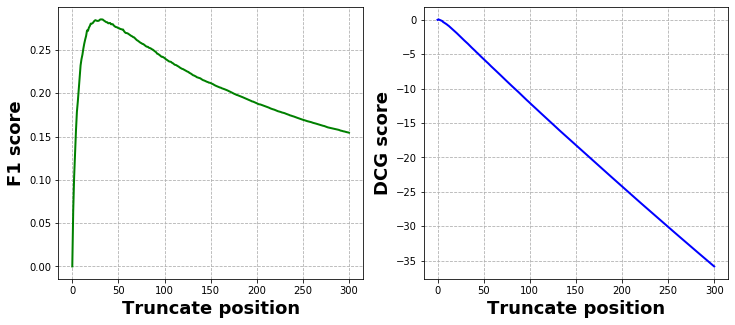

In [84]:
plt.figure(figsize=(16, 7))
x = np.arange(301)


plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.grid(linestyle = "--")
plt.plot(x, f1_bm25, color="green",linewidth=2.)
plt.xlabel('Truncate position', fontsize=18,fontweight='bold')
plt.ylabel('F1 score', fontsize=18,fontweight='bold')

plt.subplot(1, 2, 2)
plt.grid(linestyle = "--")
plt.plot(x, dcg_bm25, color="blue",linewidth=2.)
plt.xlabel('Truncate position', fontsize=18,fontweight='bold')
plt.ylabel('DCG score', fontsize=18,fontweight='bold')

plt.show()

Text(0, 0.5, 'DCG score')

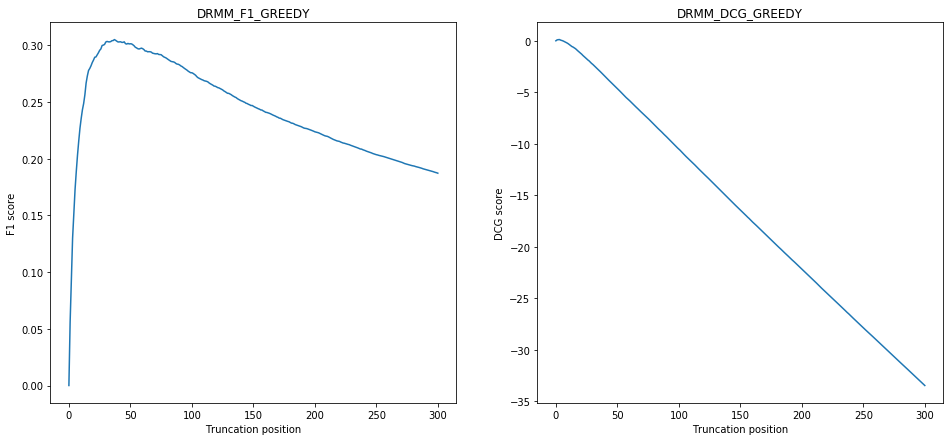

In [8]:
plt.figure(figsize=(16, 7))
x = np.arange(301)
plt.subplot(1, 2, 1)
plt.plot(x, f1_drmm)
plt.title('DRMM_F1_GREEDY')
plt.xlabel('Truncation position')
plt.ylabel('F1 score')

plt.subplot(1, 2, 2)
plt.plot(x, dcg_drmm)
plt.title('DRMM_DCG_GREEDY')
plt.xlabel('Truncation position')
plt.ylabel('DCG score')

Text(0, 0.5, 'DCG score')

<Figure size 1152x504 with 0 Axes>

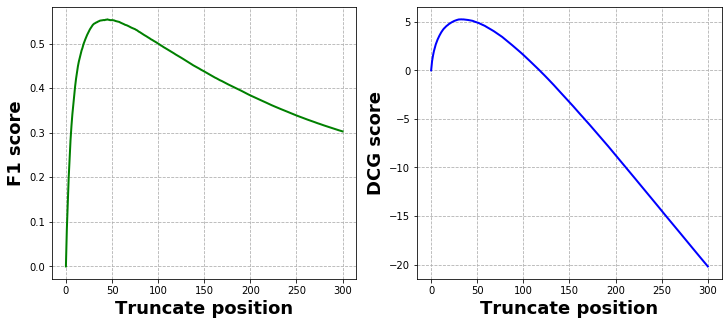

In [85]:
plt.figure(figsize=(16, 7))
x = np.arange(301)
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.grid(linestyle = "--")
plt.plot(x, f1_drmm_tks, color="green",linewidth=2.)
plt.xlabel('Truncate position', fontsize=18,fontweight='bold')
plt.ylabel('F1 score', fontsize=18,fontweight='bold')

plt.subplot(1, 2, 2)
plt.grid(linestyle = "--")
plt.plot(x, dcg_drmm_tks, color="blue",linewidth=2.)
plt.xlabel('Truncate position', fontsize=18,fontweight='bold')
plt.ylabel('DCG score', fontsize=18,fontweight='bold')

* 在bm25和drmm上，使用dcg指标的时候，需要控制惩罚项，否则会因为惩罚项太大，导致模型过分小心，甚至产生从0截断的情况，使得截断毫无意义；

* 在我们使用的所有数据集上，f1指标均可作为优化指标；

## 检索偏差分析

In [74]:
DATASET_BASE = ROBUST_BASE
dataset_name = 'bm25'
with open('{}/{}_train.pkl'.format(DATASET_BASE, dataset_name), 'rb') as f:
    train_data = pickle.load(f)
with open('{}/{}_test.pkl'.format(DATASET_BASE, dataset_name), 'rb') as f:
    test_data = pickle.load(f)
with open('{}/gt.pkl'.format(DATASET_BASE), 'rb') as f:
    gt = pickle.load(f)
    for key in gt: gt[key] = set(gt[key])

In [75]:
train_rl, test_rl = {}, {}
for key in train_data: 
    train_rl[key] = list(map(lambda x: 1 if x in gt[key] else 0, train_data[key].keys()))
for key in test_data:
    test_rl[key] = list(map(lambda x: 1 if x in gt[key] else 0, test_data[key].keys()))

In [76]:
all_data = train_rl.copy()
all_data.update(test_rl)
len(all_data)

240

In [77]:
from tqdm import tqdm
def countp(all_data):
    p = []
    for i in tqdm(range(1, 71)):
        total_irr = 0
        for qid in all_data:
            ir_num = i - sum(all_data[qid][:i])
            total_irr += ir_num
        p.append(total_irr / (len(all_data) * i))
    return p

In [78]:
count = 0
for qid in all_data: 
    count += sum(all_data[qid])
print(count / len(all_data))

26.033333333333335


In [79]:
p = countp(all_data)
len(p)

100%|██████████| 70/70 [00:00<00:00, 3671.99it/s]


70

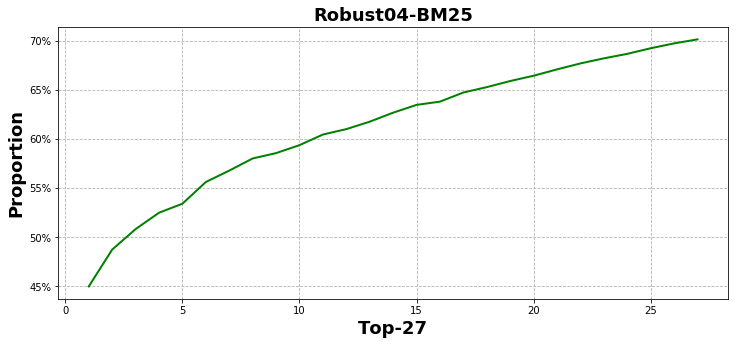

In [80]:
from matplotlib.ticker import FuncFormatter

x = list(range(1, 28))
plt.figure(figsize=(12,5))
plt.grid(linestyle = "--")
plt.plot(x,p[:27], color="green",linewidth=2.)
plt.title('Robust04-BM25', fontsize=18,fontweight='bold')
plt.xlabel('Top-27', fontsize=18,fontweight='bold')
plt.ylabel('Proportion', fontsize=18,fontweight='bold')


def to_percent(temp, position):
    return '%1.0f'%(100*temp) + '%'
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

In [38]:
pre_train = [0.9148814664253108, 0.9223573283639398, 0.925174873626101, 0.9306718242536176, 0.9343625902854648, 0.9378748580560994, 0.9398723767425591, 0.9387807109131967, 0.9409706836904963, 0.940725842269012, 0.9393533186249668, 0.9419608230054095, 0.9416693548058294, 0.9432774970296344, 0.9358919161494078, 0.9433039212826432, 0.939186541326633, 0.9398362956197568, 0.943811113157634, 0.9438620970209337, 0.9380610098729218, 0.9455018268352867, 0.945560654574703, 0.9442998656760988, 0.9430685303310448, 0.9453810570859981, 0.946372103699047, 0.946621646379556, 0.9434138933083781, 0.9452159462220896, 0.9471831471845792, 0.9456086570343488, 0.9419764480220696, 0.9459051457188686, 0.9437561385105315, 0.9445869659409346, 0.9467821395974445, 0.9414386843127075, 0.9447788769347149, 0.9444742828444151, 0.9473405274338439, 0.9458186859330234, 0.950129477108546, 0.9476178450454027, 0.9445994976410489, 0.9501887570849896, 0.9461122120946985, 0.9488135093236935, 0.9479823870282914, 0.9464020923791882, 0.9462488837475599, 0.9463874143238514, 0.9473557815686237, 0.9478252607062494, 0.9443249666968884, 0.9448689185763753, 0.949709801973969, 0.9474492695129237, 0.9449333467348914, 0.9462492777689068, 0.9423806508418218, 0.9479529496298085, 0.9462783187255538, 0.9481641530207002, 0.9460947283454432, 0.9454663939359511, 0.9478077079901507, 0.946893948649031, 0.9494874916186461, 0.9462046789206271, 0.9487463607726506, 0.9479963394817457, 0.947451610097705, 0.9474237099851827, 0.9458001193142382, 0.9457554574963644, 0.94836647061979, 0.9449406198699868, 0.9454975995429201, 0.945053205315074, 0.9469247446825834, 0.9452750150747731, 0.947973826904945, 0.945758228521405, 0.9503444716748607, 0.9470807909369424, 0.9465387802572653, 0.9482983857504813, 0.9477136118804017, 0.9436954209399976, 0.9415139991743016, 0.945009870571781, 0.9450933277251407, 0.9462691768922183, 0.947903399649635, 0.9390424291069888, 0.9461268832685223, 0.9446876197404374, 0.9467667300234092, 0.9474414348882215]
direct = [0.051177247398403874, 0.055225921009071116, 0.054866290533920746, 0.05729219457107637, 0.05958825622500486, 0.06901968024511809, 0.09504540686498171, 0.17740714837544846, 0.2599303352244906, 0.344902785180709, 0.5095372713744372, 0.6279822054925634, 0.683350135708215, 0.7520053345415316, 0.7885543009086476, 0.834992558741242, 0.8870473830946054, 0.9164707641731188, 0.9255272160259216, 0.9275314704851382, 0.938575859927708, 0.9395677009262066, 0.9425558292217623, 0.9365209091649311, 0.9440721715922161, 0.946298794856452, 0.9434872619004689, 0.9453412537392268, 0.938058163876646, 0.940950522142325, 0.9411590207483645, 0.9408482358752291, 0.940091468547584, 0.943053525958688, 0.9436141434480737, 0.9437533373461746, 0.9427985524781439, 0.9419416656623959, 0.9419443908926867, 0.9442244811234648, 0.9453650831527681, 0.9443407771405825, 0.9447861883046184, 0.9417303198425199, 0.9438009236297429, 0.9444015833300899, 0.9436413476175755, 0.9390377417616854, 0.9445684782277017, 0.9430151510641281, 0.9439355911365238, 0.9414257659940546, 0.9422716777297809, 0.9399613093183579, 0.9435448323270114, 0.9400496983796779, 0.9418523064966203, 0.9437297225812511, 0.9446107045639511, 0.9439338748868827, 0.9461813646151688, 0.9399662923726732, 0.9446508066976423, 0.9422833005128682, 0.944369441607461, 0.9402239946406338, 0.9443965075479892, 0.9444928355183482, 0.9427858733952199, 0.9440286867734898, 0.9442551597356831, 0.9425072258720686, 0.9468564655160495, 0.944706687791057, 0.9465375251681296, 0.9451722429600782, 0.9451438137948172, 0.9423208813862246, 0.9437315700526144, 0.9442399791912507, 0.9425635877511134, 0.9403639487537329, 0.9477333800163165, 0.9459613130764142, 0.9468613395134052, 0.9388326567783115, 0.9425373626355112, 0.9447690267055711, 0.9463668543784199, 0.9406395305142853, 0.946042704029619, 0.9454153030724542, 0.9424277184483509, 0.9469739648863084, 0.946544153921867, 0.9456708759991125, 0.9432362417595327, 0.9452774452670326, 0.943824444369775, 0.9460264403761028]

In [39]:
direct[14]

0.7885543009086476

Text(0, 0.5, 'AUC')

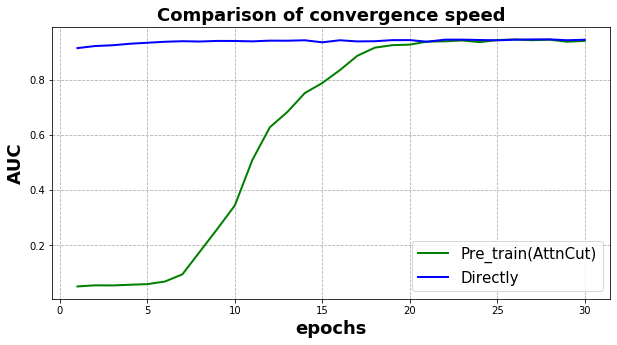

In [40]:
from matplotlib.ticker import FuncFormatter

x = list(range(1, 31))
plt.figure(figsize=(10,5))
plt.grid(linestyle = "--")
plt.plot(x,direct[:30], color="green",linewidth=2.,label='Pre_train(AttnCut)')
plt.plot(x,pre_train[:30], color="blue",linewidth=2.,label='Directly')
plt.legend(fontsize=15)
plt.title('Comparison of convergence speed', fontsize=18,fontweight='bold')
plt.xlabel('epochs', fontsize=18,fontweight='bold')
plt.ylabel('AUC', fontsize=18,fontweight='bold')